# SET UP

In [47]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurations
pd.set_option('display.max_columns', None)

In [29]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [30]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [55]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 100 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles']]


In [17]:
# Initialize empty columns of calculations into dataframes

'''
for x in years:
    df = data[x]
    df['xAtt'] = np.nan
    df['xCmp'] = 
'''

"\nfor x in years:\n    df = data[x]\n    df['xAtt'] = np.nan\n    df['xCmp'] = \n"

In [51]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


# CALCULATIONS

TODO:
- [ ] Calculate league averages
- [ ] Calculate OL factors
- [ ] See if we can weigh xCmp
- [ ] Evaluate differences between xCmp and actual completions

In [18]:
# xAtt = pass attempts - throwaways - spikes
# This discounts pass attempts where no receiver was intentionally targeted
#
# NOTE: It is possible we may not want to subtract throwaways since it doesn't 
# account if there was a receiver open but the QB could not make the read

def xAtt(row):
    return row['pass_att'] - row['pass_throwaways'] - row['pass_spikes']

In [19]:
# xCmp = OnTgt throws - Bad throws + Drops
# This adds up pass attempts that where good enough to be completions (i.e. OnTgt throws) and drops that should've been caught. 
# It also subtracts pass attempts that are typically not completed  (i.e. Bad throws). These all add up to what the QB's total 
# number of completions should have been based on these stats.
#
# NOTE: the definition of "OnTgt" and "bad" throws is subjective. According
# to PFR, "bad" throws are passes that cannot be caught with "normal" effort, although
# this doesn't necessarily mean the pass is uncatchable. Similarly, "OnTgt" is not 
# specifically defined either.

def xCmp(row):
    return row['pass_on_target'] - row['pass_poor_throws'] + row['pass_drops']

In [59]:
# xCmp% = xCmp/xAtt

def xCmpPct(row):
    return float(row['xCmp']/row['xAtt']) * 100

In [60]:
# basic cmp%, i.e. cmp% = cmp/att

def cmpPct(row):
    return float(row['pass_cmp']/row['pass_att']) * 100

In [21]:
# cmpDiff = xCmp - Cmp

def cmpDiff(row):
    return row['xCmp'] - row['pass_cmp']

In [61]:
# cmpPctDiff = xCmp% - CmpPct

def cmpPctDiff(row):
    return float(row['xCmpPct']) - float(row['cmpPct'])

# EXPORTING NEW DATAFRAMES

In [62]:
# Add in calculations into dataframes

for x in years:
    df = data[x]
    df['xAtt'] = df.apply(xAtt, axis=1)
    df['xCmp'] = df.apply(xCmp, axis=1)
    df['xCmpPct'] = df.apply(xCmpPct, axis=1)
    df['cmpPct'] = df.apply(cmpPct, axis=1)
    df['cmpDiff'] = df.apply(cmpDiff, axis=1)
    df['cmpPctDiff'] = df.apply(cmpPctDiff, axis=1)

In [33]:
# Export dfs to CSVs

for x in years:
    df = data[x]
    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)

# CREATING VISUALS

In [109]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


### Tests

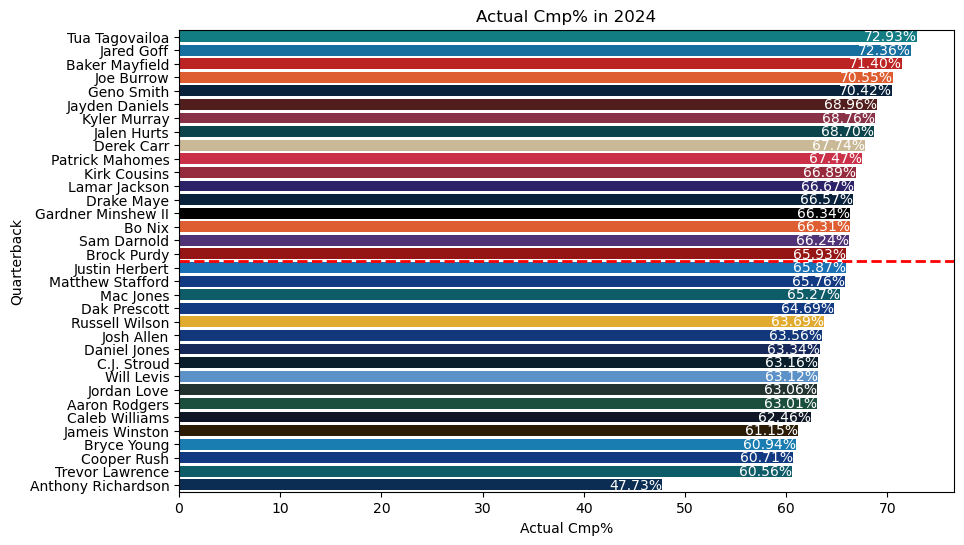

In [114]:
# Plot 2024 data as a test

cmp24 = statGrapher(data[24], 'cmpPct', 'Actual Cmp%')

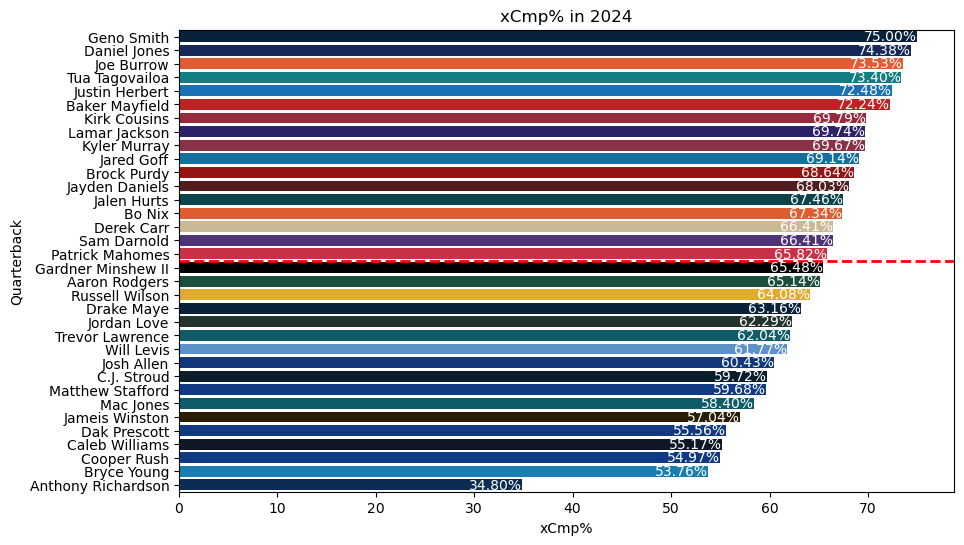

In [115]:
# 2024 xCmp%

xCmp24 = statGrapher(data[24], 'xCmpPct', 'xCmp%')

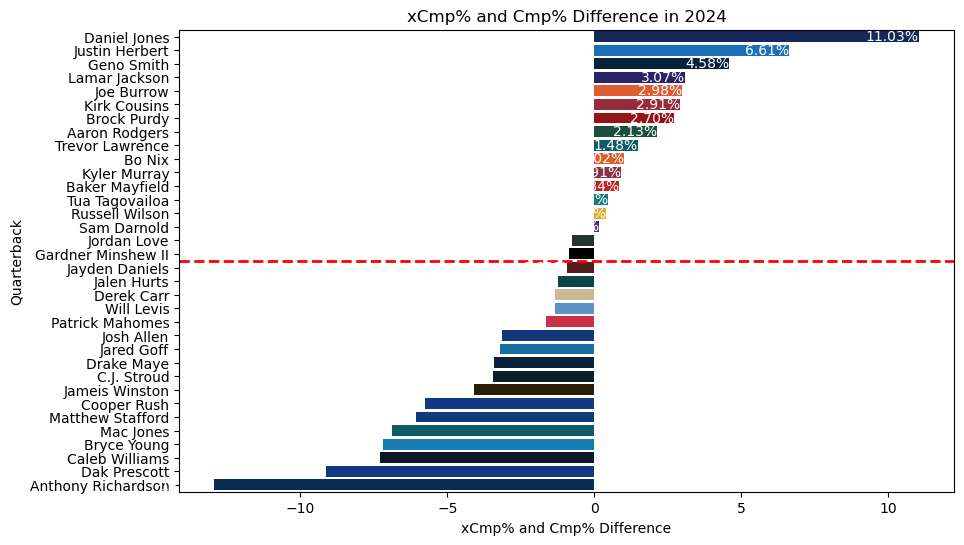

In [112]:
cmpDiff24 = statGrapher(data[24], 'cmpPctDiff', 'xCmp% and Cmp% Difference') 

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

In [64]:
data[19].head()

,name_display,team_name_abbr,pass_cmp,pass_att,pass_batted_passes,pass_throwaways,pass_spikes,pass_drops,pass_poor_throws,pass_on_target,pocket_time,pass_blitzed,pass_hurried,pass_hits,pass_pressured,rush_scrambles,xAtt,xCmp,xCmpPct,cmpPct,cmpDiff,cmpPctDiff
0,Jared Goff,LAR,394,626,17,15,1,27,123,437,2.6,219,52,48,122,10,610,341,55.901639,62.939297,-53,-7.037658
1,Jameis Winston,TAM,380,626,11,22,2,23,124,421,2.5,241,60,54,161,31,602,320,53.156146,60.702875,-60,-7.546729
2,Matt Ryan,ATL,408,616,19,27,1,17,86,443,2.5,199,54,62,164,21,588,374,63.605442,66.233766,-34,-2.628324
3,Tom Brady,NWE,373,613,6,40,0,34,118,419,2.5,198,55,37,119,3,573,335,58.464223,60.848287,-38,-2.384064
4,Carson Wentz,PHI,388,607,16,10,1,28,106,431,2.4,184,67,53,157,28,596,353,59.228188,63.920923,-35,-4.692735
